# Lab Assignment Seven: Wide and Deep Network Architectures
Erik Gabrielsen, Danh Nguyen, Conrad Appel

In this lab, you will select a prediction task to perform on your dataset, evaluate two different deep learning architectures and tune hyper-parameters for each architecture. If any part of the assignment is not clear, ask the instructor to clarify. 

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

## Dataset Selection

Select a dataset identically to lab one. That is, the dataset must be table data. In terms of generalization performance, it is helpful to have a large dataset for building a wide and deep network. It is also helpful to have many different categorical features to create the embeddings and cross-product embeddings. It is fine to perform binary classification or multi-class classification.

## Grading Rubric

### Preparation (40 points total)
[10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

[10 points] Identify groups of features in your data that should be combined into cross-product features. 

[10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

### Modeling (50 points total)
[20 points] Create a combined wide and deep network to classify your data using tensorflow.

[20 points] Investigate generalization performance by altering the number of layers. Try at least two different deep network architectures. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. 

[10 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve.   

### Exceptional Work (10 points total)
You have free reign to provide additional analyses.
One idea: Investigate which cross-product features are most important and hypothesize why.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import roc_curve, auc
from scipy import interp

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

df_train_orig = pd.read_csv('~/Downloads/bank-additional/bank-additional-full.csv', sep=';') # read in the csv file

df_test_orig = pd.read_csv('~/Downloads/bank-additional/bank-additional.csv', sep=';')

df_test_orig = df_test_orig.ix[1:]
print(df_train_orig.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [3]:
from copy import deepcopy
df_train = deepcopy(df_train_orig)
df_test = deepcopy(df_test_orig)

In [4]:
# Cleaning data - getting rid of null values

df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
5,32,services,single,university.degree,no,no,no,cellular,sep,thu,...,3,999,2,failure,-1.1,94.199,-37.5,0.884,4963.6,no


## Preprocessing


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

encoders = dict() 
categorical_headers = ['job','marital','day_of_week',
                       'poutcome','month','default','housing','loan','education']

for col in categorical_headers+['y']:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    
    if col=="y":
        tmp = LabelEncoder()
        df_train[col] = tmp.fit_transform(df_train[col])
        df_test[col] = tmp.transform(df_test[col])
    else:
        encoders[col] = LabelEncoder()
        df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
        df_test[col+'_int'] = encoders[col].transform(df_test[col])


#normalize continuous attributes
numeric_headers = ["age", "duration", "campaign", "pdays","previous"]

for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))

In [6]:
df_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,y,job_int,marital_int,day_of_week_int,poutcome_int,month_int,default_int,housing_int,loan_int,education_int
0,1.533034,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,3,1,1,1,6,0,0,0,0
1,1.628993,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,7,1,1,1,6,1,0,0,3
2,-0.290186,services,married,high.school,no,yes,no,telephone,may,mon,...,0,7,1,1,1,6,0,2,0,3
3,-0.002309,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,0,1,1,1,6,0,0,0,1
4,1.533034,services,married,high.school,no,no,yes,telephone,may,mon,...,0,7,1,1,1,6,0,0,2,3


In [7]:
print(df_train.y.value_counts())
print(df_train.info())

0    36548
1     4640
Name: y, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 30 columns):
age                41188 non-null float64
job                41188 non-null object
marital            41188 non-null object
education          41188 non-null object
default            41188 non-null object
housing            41188 non-null object
loan               41188 non-null object
contact            41188 non-null object
month              41188 non-null object
day_of_week        41188 non-null object
duration           41188 non-null float64
campaign           41188 non-null float64
pdays              41188 non-null float64
previous           41188 non-null float64
poutcome           41188 non-null object
emp.var.rate       41188 non-null float64
cons.price.idx     41188 non-null float64
cons.conf.idx      41188 non-null float64
euribor3m          41188 non-null float64
nr.employed        41188 non-null float64
y                

## Starting Tensorflow

In [11]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib import layers
from tensorflow.contrib.learn.python import SKCompat
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
from sklearn import metrics as mt

tf.logging.set_verbosity(tf.logging.WARN) # control the verbosity of tensor flow

In [15]:
def plot_roc(y_true, y_hat):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    classes = np.unique(y_hat)
    perclass_mean_tpr = 0.0
    roc_auc = 0
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_true,
                                         y_hat,
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr

    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC for ensemble, AUC=%0.4f'
                     %(roc_auc))
    plt.legend(loc='best')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC Curve')

In [29]:
y_train = df_train['y'].values.astype(np.int)
y_test = df_test['y'].values.astype(np.int)
categorical_headers_ints = [x+'_int' for x in categorical_headers]

## Modeling with Learn Estimator

In [21]:
# let's start by just using the tflearn library out of the box on the data we have
def my_model(features, targets, mode):
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    # =====SETUP ARCHITECTURE=====
    # we can use functions from learn to add layers and complexity to the model
    # pass features through one hidden layer with relu activation
    features = layers.relu(features, num_outputs=50) 
    # now pass the features through a fully connected layer
    features = layers.fully_connected(features, num_outputs=1) 
    # and pass them through a sigmoid activation
    output_layer = tf.sigmoid(features) 
    # reshape the output to be one dimensional
    predictions = tf.reshape(output_layer, [-1])
    
    # depending on the mode, we may not want to evaluate these
    loss_mse = None
    train_op = None
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    if mode != learn.ModeKeys.INFER:
        # =====LOSS=======
        # we want to use MSE as our loss function, but could also choose 
        # cross entropy, or other objective functions here
        loss_mse = tf.losses.mean_squared_error(targets, predictions) 
    
    # Configure the Training Op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        # =====OPTIMIZER PARAMS========
        # now let's setup how we want thing to optimize 
        train_op = layers.optimize_loss(
            loss=loss_mse, 
            global_step=tf.contrib.framework.get_global_step(),
            optimizer='Adagrad', # adaptive gradient, so that the learning rate is not SO important
            learning_rate=0.1)
    
    # what format to have the output in when calling clf.predict?
    predictions_out = predictions>0.5
    return model_fn_lib.ModelFnOps(
      mode=mode, predictions=predictions_out, loss=loss_mse, train_op=train_op)

In [44]:
# Let's start with the TF example (manipulated to work with new syntax)
# https://www.tensorflow.org/tutorials/wide_and_deep
def process_input(df, label_header, categ_headers, numeric_headers):
    # input: what ever you need it to be
    # output: (dict of feature columns as tensors), (labels as tensors)
    
    # ========Process Inputs=========
    # Creates a dictionary mapping from each continuous feature column name (k) to
    # the values of that column stored in a constant Tensor.
    continuous_cols = {k: tf.expand_dims( # make it a column vector
                            tf.cast( # cast to a float32
                                tf.constant(df[k].values), 
                                tf.float32), 
                            1)
                       for k in numeric_headers}
    
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored as constant Tensors (numeric)
    # then use tensor flow to one hot encode them using the given number of classes 
    categorical_cols = {k: tf.one_hot(indices=tf.constant(df[k].values),
                                      depth=len(encoders[k[:-4]].classes_)) 
                        for k in categ_headers}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(continuous_cols)
    feature_cols.update(categorical_cols)
    
    # Convert the label column into a constant Tensor.
    label = None
    if label_header is not None:
        label = tf.constant(df[label_header].values)
        
    return feature_cols, label

In [45]:
# update the model to take input features as a dictionary
def my_model(dict_features, targets, mode):
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    #=======DECODE FEATURES================
    # now let's combine the tensors from the input dictionary
    # into a list of the feature columns
    features = []
    for col in numeric_headers:
        features.append(dict_features[col])
    
    # also add in the one hot encoded features
    for col in categorical_headers_ints:
        features.append(dict_features[col])
    
    # now we can just combine all the features together
    features = tf.concat(values=features,axis=1)
    
    # =====SETUP ARCHITECTURE=====
    # we can use functions from learn to add layers and complexity to the model
    # pass features through one hidden layer with relu activation
    features = layers.relu(features, num_outputs=50) 
    # now pass the features through a fully connected layer
    features = layers.fully_connected(features, num_outputs=1) 
    # and pass them through a sigmoid activation
    output_layer = tf.sigmoid(features) 
    # reshape the output to be one dimensional
    predictions = tf.reshape(output_layer, [-1])
    
    # depending on the mode, we may not want to evaluate these
    loss_mse = None
    train_op = None
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    if mode != learn.ModeKeys.INFER:
        # =====LOSS=======
        # we want to use MSE as our loss function
        loss_mse = tf.losses.mean_squared_error(targets, predictions) 
    
    if mode == learn.ModeKeys.TRAIN:
        # =====OPTIMIZER PARAMS========
        # now let's setup how we want thing to optimize 
        train_op = layers.optimize_loss(
            loss=loss_mse, 
            global_step=tf.contrib.framework.get_global_step(),
            optimizer='Adagrad', # adaptive gradient, so that the learning rate is not SO important 
            learning_rate=0.1)
    
    # what format to have the output in when calling clf.predict?
    predictions_out = predictions>0.5
    
    return model_fn_lib.ModelFnOps(
      mode=mode, predictions={'y':predictions_out}, loss=loss_mse, train_op=train_op)

In [46]:
%%time
clf = learn.Estimator(model_fn=my_model)

# when we provide the process function, they expect us to control the mini-batch
clf.fit(input_fn=lambda:process_input(df_train,'y',categorical_headers_ints, numeric_headers), 
        steps=500)

CPU times: user 1min 10s, sys: 9.87 s, total: 1min 20s
Wall time: 38.2 s


In [120]:
yhat = clf.predict(input_fn=lambda:process_input(df_test,None,categorical_headers_ints, numeric_headers))
# the output is now an iterable value, so we need to step over it
yhat = [x['y'] for x in yhat]
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[3609   58]
 [ 352   99]] 0.900437105391


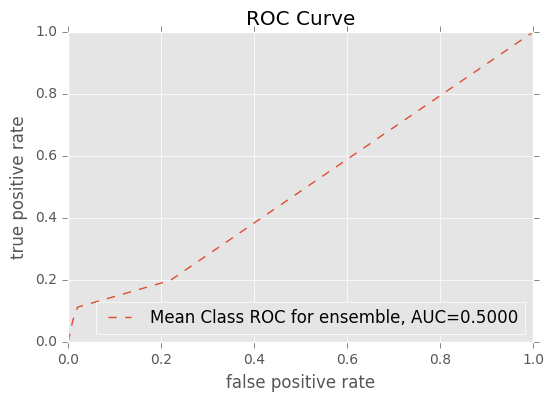

In [121]:
plot_roc(y_test, yhat)

In [30]:
# stratified part

cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)

for train_index, test_index in cv.split(df_train, df_train.y):
#     print(df_train.loc[test_index])
    clf = learn.Estimator(model_fn=my_model)

    # when we provide the process function, they expect us to control the mini-batch
    clf.fit(input_fn=lambda:process_input(df_train.loc[train_index],'y',categorical_headers_ints, numeric_headers), 
        steps=500)
    
    yhat = clf.predict(input_fn=lambda:process_input(df_train.loc[test_index],None,categorical_headers_ints, numeric_headers))
    # the output is now an iterable value, so we need to step over it
    yhat = [x['y'] for x in yhat]
    print(mt.confusion_matrix(y_train[test_index],yhat),mt.accuracy_score(y_train[test_index],yhat))

[[7295   15]
 [ 910   18]] 0.887715464919


## Adding Crossed Columns

In [47]:
# Now lets create a wide model 
# https://www.tensorflow.org/tutorials/wide_and_deep
def process_input(df, label_header, categ_headers, numeric_headers):
    # input: what ever you need it to be
    # output: (dict of feature columns as tensors), (labels as tensors)
    
    # ========Process Inputs=========
    # not much changes here, except we leave the numerics as tc.constants
    continuous_cols = {k: tf.constant(df[k].values) for k in numeric_headers}
      
    # and we shift these tensors to be sparse one-hot encoded values
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(
                              indices=[[i, 0] for i in range(df[k].size)],
                              values=df[k].values,
                              dense_shape=[df[k].size, 1])
                        for k in categ_headers}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(categorical_cols)
    feature_cols.update(continuous_cols)
    
    # Convert the label column into a constant Tensor.
    label = None
    if label_header is not None:
        label = tf.constant(df[label_header].values)
        
    return feature_cols, label

In [48]:
# update the model to take input features as a dictionary
def setup_wide_columns():
    # let's create the column structure that the learn API can expect
    
    wide_columns = []
    # add in each of the categorical columns
    for col in categorical_headers:
        wide_columns.append(layers.sparse_column_with_keys(col, keys=encoders[col].classes_))
        
    # also add in some specific crossed columns
    cross_columns = [('marital','housing')]
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=encoders[tup[0]].classes_),
                 layers.sparse_column_with_keys(tup[1], keys=encoders[tup[1]].classes_)],
            hash_bucket_size=int(1e4))
        )
                        
    return wide_columns

In [49]:
%%time

# ignore all the deprecations that the learn API needs to deal with... ugh
tf.logging.set_verbosity(tf.logging.ERROR)

# setup 
wide_columns = setup_wide_columns()
input_wrapper = lambda:process_input(df_train,'y',categorical_headers, numeric_headers)
output_wrapper = lambda:process_input(df_test,None,categorical_headers, numeric_headers)

clf = learn.LinearClassifier(feature_columns=wide_columns)

# when we provide the process function, they expect us to control the mini-batch
clf.fit(input_fn=input_wrapper, steps=300)

yhat = clf.predict(input_fn=output_wrapper)
# the output is now an iterable value, so we need to step over it
yhat = [x for x in yhat]
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[3635   32]
 [ 390   61]] 0.897523069451
CPU times: user 1min 42s, sys: 11.5 s, total: 1min 53s
Wall time: 1min 3s


In [50]:
# update the model to take input features as a dictionary
def setup_deep_columns():
    # now make up the deep columns
    
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_headers:
        
        tmp = layers.sparse_column_with_keys(col, keys=encoders[col].classes_)
        
        deep_columns.append(
            layers.embedding_column(tmp, dimension=8)
        )
        
        
    # and add in the regular dense features 
    for col in numeric_headers:
        deep_columns.append(
            layers.real_valued_column(col)
        )
                    
    return deep_columns

In [109]:
%%time 

# setup deep columns
deep_columns = setup_deep_columns()
clf = learn.DNNClassifier(feature_columns=deep_columns, hidden_units=[100, 50])

clf.fit(input_fn=input_wrapper, steps=300)

yhat = clf.predict(input_fn=output_wrapper)
# the output is now an iterable value, so we need to step over it
yhat = [x for x in yhat]
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[3563  104]
 [ 260  191]] 0.911607576493
CPU times: user 4min 54s, sys: 58.5 s, total: 5min 52s
Wall time: 2min 37s


In [53]:
# update the model to take input features as a dictionary
def setup_wide_deep_columns():
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    wide_columns = []
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_headers:
        wide_columns.append(
            layers.sparse_column_with_keys(col, keys=encoders[col].classes_)
        )
        
        dim = round(np.log2(len(encoders[col].classes_)))
        deep_columns.append(
            layers.embedding_column(wide_columns[-1], dimension=dim)
        )
        
    # also add in some specific crossed columns
    cross_columns = [('marital','housing')]
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=encoders[tup[0]].classes_),
                 layers.sparse_column_with_keys(tup[1], keys=encoders[tup[1]].classes_)],
            hash_bucket_size=int(1e4))
        )
        
        
    # and add in the regular dense features 
    for col in numeric_headers:
        deep_columns.append(
            layers.real_valued_column(col)
        )
                    
    return wide_columns, deep_columns

In [111]:
%%time

wide_columns, deep_columns = setup_wide_deep_columns()
clf = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns,
                        dnn_feature_columns=deep_columns,
                        dnn_hidden_units=[100, 50])


clf.fit(input_fn=input_wrapper, steps=2500)

yhat = clf.predict(input_fn=output_wrapper)
# the output is now an iterable value, so we need to step over it
yhat = [x for x in yhat]
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[3582   85]
 [ 278  173]] 0.911850412822
CPU times: user 18min 14s, sys: 4min 8s, total: 22min 23s
Wall time: 7min 52s


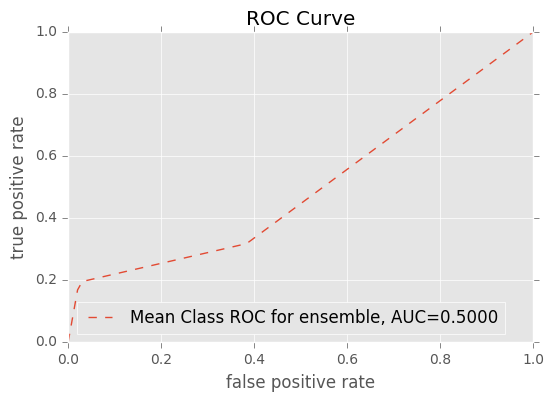

In [113]:
plot_roc(y_test, yhat)

In [54]:
# attempting to statify
wide_columns, deep_columns = setup_wide_deep_columns()
clf = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns,
                        dnn_feature_columns=deep_columns,
                        dnn_hidden_units=[100, 50])

for train_index, test_index in cv.split(df_train, df_train.y):
    input_wrapper = lambda:process_input(df_train.loc[train_index],'y',categorical_headers, numeric_headers)
    output_wrapper = lambda:process_input(df_train.loc[test_index],None,categorical_headers, numeric_headers)
    
    clf.fit(input_fn=input_wrapper, steps=2500)

    yhat = clf.predict(input_fn=output_wrapper)
    # the output is now an iterable value, so we need to step over it
    yhat = [x for x in yhat]
    print(mt.confusion_matrix(y_train[test_index],yhat),mt.accuracy_score(y_train[test_index],yhat))
    

[[7110  200]
 [ 579  349]] 0.905438213159


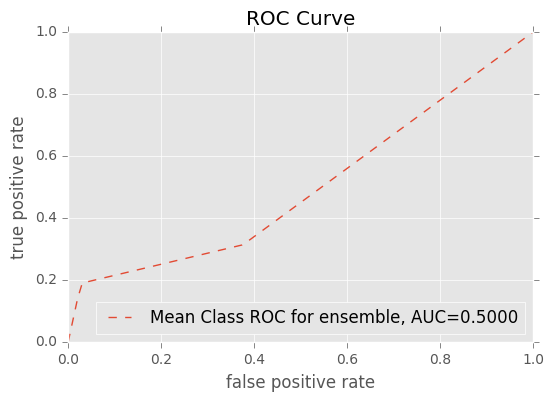

In [55]:
plot_roc(y_train[test_index], yhat)